<a href="https://colab.research.google.com/github/Ryukijano/Pytorch_3d_ryu/blob/main/implicitron_volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# A simple model using Implicitron

In this demo, we use the VolumeRenderer from PyTorch3D as a custom implicit function in Implicitron. We will see
* some of the main objects in Implicitron
* how to plug in a custom part of a model

## 0. Install and import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:


In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61429 sha256=700c94768f6579234e9473dc8cab53da1a8ba0c9110e2259ba1567cd94d96ac5
  Stored in directory: /root/.cache/pip/wheels/83/42/02/66178d16e5c44dc26d309931834956baeda371956e86fbd876
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=baa5c6b8773d8d491ef5790f094797b6b2000083e79175829948fe261d5af444
  Stored in directory: /root/.cache/pip/wheels/c1/13/6d/441d8f2af76ee6d2a3e67eebb1d0c556fefcee0a8b32266a8e
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py39_cu118_pyt200/down

Ensure omegaconf and visdom are installed. If not, run this cell. (It should not be necessary to restart the runtime.)

In [3]:
!pip install omegaconf visdom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=955418d49939f235368fa599079af88ade4f3ecbe0c6e292668d33dad63a9e20
  Stored in directory: /root/.cache/pip/wheels/23/cf/80/f3efa822e6ab23277902ee9165fe772eeb1dfb8014f359020a
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=2ba58ce03a5002242f584cda5dfb14c65cf321870d19e696b2fc4afa2f6ca20f
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built antlr4-pyth

In [1]:
import logging
from typing import Tuple

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from IPython.display import HTML
from omegaconf import OmegaConf
from PIL import Image
from pytorch3d.implicitron.dataset.dataset_base import FrameData
from pytorch3d.implicitron.dataset.rendered_mesh_dataset_map_provider import RenderedMeshDatasetMapProvider
from pytorch3d.implicitron.models.generic_model import GenericModel
from pytorch3d.implicitron.models.implicit_function.base import ImplicitFunctionBase, ImplicitronRayBundle
from pytorch3d.implicitron.models.renderer.base import EvaluationMode
from pytorch3d.implicitron.tools.config import get_default_args, registry, remove_unused_components
from pytorch3d.renderer.implicit.renderer import VolumeSampler
from pytorch3d.structures import Volumes
from pytorch3d.vis.plotly_vis import plot_batch_individually, plot_scene

In [2]:
output_resolution = 80

In [3]:
torch.set_printoptions(sci_mode=False)

## 1. Load renders of a mesh (the cow mesh) as a dataset

A dataset's train, val and test parts in Implicitron are represented as a `dataset_map`, and provided by an implementation of `DatasetMapProvider`. 
`RenderedMeshDatasetMapProvider` is one which generates a single-scene dataset with only a train component by taking a mesh and rendering it.
We use it with the cow mesh.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path data/cow_mesh.
If running locally, the data is already available at the correct path.

In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-04-19 07:11:00--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.103, 52.84.162.20, 52.84.162.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.02s   

2023-04-19 07:11:00 (13.4 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-04-19 07:11:00--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.103, 52.84.162.20, 52.84.162.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[===

In [5]:
cow_provider = RenderedMeshDatasetMapProvider(
    data_file="data/cow_mesh/cow.obj",
    use_point_light=False,
    resolution=output_resolution,
)

In [6]:
dataset_map = cow_provider.get_dataset_map()
tr_cameras = [training_frame.camera for training_frame in dataset_map.train]

In [7]:
# The cameras are all in the XZ plane, in a circle about 2.7 from the origin
centers = torch.cat([i.get_camera_center() for i in tr_cameras])
print(centers.min(0).values)
print(centers.max(0).values)

tensor([-2.6978,  0.0000, -2.6912])
tensor([2.6978, 0.0000, 2.7000])


In [8]:
# visualization of the cameras
plot = plot_scene({"k": {i: camera for i, camera in enumerate(tr_cameras)}}, camera_scale=0.25)
plot.layout.scene.aspectmode = "data"
plot

## 2. Custom implicit function 🧊

At the core of neural rendering methods are functions of spatial coordinates called implicit functions, which are used in some kind of rendering process.
(Often those functions can additionally take other data as well, such as view direction.)
A common rendering process is ray marching over densities and colors provided by an implicit function.
In our case, taking samples from a 3D volume grid is a very simple function of spatial coordinates. 

Here we define our own implicit function, which uses PyTorch3D's existing functionality for sampling from a volume grid.
We do this by subclassing `ImplicitFunctionBase`.
We need to register our subclass with a special decorator.
We use Python's dataclass annotations for configuring the module.

In [9]:
@registry.register
class MyVolumes(ImplicitFunctionBase, torch.nn.Module):
    grid_resolution: int = 50  # common HWD of volumes, the number of voxels in each direction
    extent: float = 1.0  # In world coordinates, the volume occupies is [-extent, extent] along each axis

    def __post_init__(self):
        # We have to call this explicitly if there are other base classes like Module
        super().__init__()

        # We define parameters like other torch.nn.Module objects.
        # In this case, both our parameter tensors are trainable; they govern the contents of the volume grid.
        density = torch.full((self.grid_resolution, self.grid_resolution, self.grid_resolution), -2.0)
        self.density = torch.nn.Parameter(density)
        color = torch.full((3, self.grid_resolution, self.grid_resolution, self.grid_resolution), 0.0)
        self.color = torch.nn.Parameter(color)
        self.density_activation = torch.nn.Softplus()

    def forward(
        self,
        ray_bundle: ImplicitronRayBundle,
        fun_viewpool=None,
        global_code=None,
    ):
        densities = self.density_activation(self.density[None, None])
        voxel_size = 2.0 * float(self.extent) / self.grid_resolution
        features = self.color.sigmoid()[None]

        # Like other PyTorch3D structures, the actual Volumes object should only exist as long
        # as one iteration of training. It is local to this function.

        volume = Volumes(densities=densities, features=features, voxel_size=voxel_size)
        sampler = VolumeSampler(volumes=volume)
        densities, features = sampler(ray_bundle)

        # When an implicit function is used for raymarching, i.e. for MultiPassEmissionAbsorptionRenderer,
        # it must return (densities, features, an auxiliary tuple)
        return densities, features, {}


## 3. Construct the model object.

The main model object in PyTorch3D is `GenericModel`, which has pluggable components for the major steps, including the renderer and the implicit function(s).
There are two ways to construct it which are equivalent here.

In [10]:
CONSTRUCT_MODEL_FROM_CONFIG = True
if CONSTRUCT_MODEL_FROM_CONFIG:
    # Via a DictConfig - this is how our training loop with hydra works
    cfg = get_default_args(GenericModel)
    cfg.implicit_function_class_type = "MyVolumes"
    cfg.render_image_height=output_resolution
    cfg.render_image_width=output_resolution
    cfg.loss_weights={"loss_rgb_huber": 1.0}
    cfg.tqdm_trigger_threshold=19000
    cfg.raysampler_AdaptiveRaySampler_args.scene_extent= 4.0
    gm = GenericModel(**cfg)
else:
    # constructing GenericModel directly
    gm = GenericModel(
        implicit_function_class_type="MyVolumes",
        render_image_height=output_resolution,
        render_image_width=output_resolution,
        loss_weights={"loss_rgb_huber": 1.0},
        tqdm_trigger_threshold=19000,
        raysampler_AdaptiveRaySampler_args = {"scene_extent": 4.0}
    )

    # In this case we can get the equivalent DictConfig cfg object to the way gm is configured as follows
    cfg = OmegaConf.structured(gm)


 The default renderer is an emission-absorbtion raymarcher. We keep that default.

In [11]:
# We can display the configuration in use as follows.
remove_unused_components(cfg)
yaml = OmegaConf.to_yaml(cfg, sort_keys=False)
%page -r yaml

In [12]:
device = torch.device("cuda:0")
gm.to(device)
assert next(gm.parameters()).is_cuda

## 4. train the model 

In [13]:
train_data_collated = [FrameData.collate([frame.to(device)]) for frame in dataset_map.train]

In [14]:
gm.train()
optimizer = torch.optim.Adam(gm.parameters(), lr=0.1)

In [16]:
iterator = tqdm.tqdm(range(2000))
for n_batch in iterator:
    optimizer.zero_grad()

    frame = train_data_collated[n_batch % len(dataset_map.train)]
    out = gm(**frame, evaluation_mode=EvaluationMode.TRAINING)
    out["objective"].backward()
    if n_batch % 100 == 0:
        iterator.set_postfix_str(f"loss: {float(out['objective']):.5f}")
    optimizer.step()

100%|██████████| 2000/2000 [00:24<00:00, 80.70it/s, loss: 0.01274]


## 5. Evaluate the module

We generate complete images from all the viewpoints to see how they look.

In [17]:
def to_numpy_image(image):
    # Takes an image of shape (C, H, W) in [0,1], where C=3 or 1
    # to a numpy uint image of shape (H, W, 3)
    return (image * 255).to(torch.uint8).permute(1, 2, 0).detach().cpu().expand(-1, -1, 3).numpy()
def resize_image(image):
    # Takes images of shape (B, C, H, W) to (B, C, output_resolution, output_resolution)
    return torch.nn.functional.interpolate(image, size=(output_resolution, output_resolution))

gm.eval()
images = []
expected = []
masks = []
masks_expected = []
for frame in tqdm.tqdm(train_data_collated):
    with torch.no_grad():
        out = gm(**frame, evaluation_mode=EvaluationMode.EVALUATION)

    image_rgb = to_numpy_image(out["images_render"][0])
    mask = to_numpy_image(out["masks_render"][0])
    expd = to_numpy_image(resize_image(frame.image_rgb)[0])
    mask_expected = to_numpy_image(resize_image(frame.fg_probability)[0])

    images.append(image_rgb)
    masks.append(mask)
    expected.append(expd)
    masks_expected.append(mask_expected)

100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


We draw a grid showing predicted image and expected image, followed by predicted mask and expected mask, from each viewpoint. 
This is a grid of four rows of images, wrapped in to several large rows, i.e..
<small><center>
```
┌────────┬────────┐           ┌────────┐
│pred    │pred    │           │pred    │
│image   │image   │           │image   │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│image   │image   │  ...      │image   │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│pred    │pred    │           │pred    │
│mask    │mask    │           │mask    │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│mask    │mask    │           │mask    │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│pred    │pred    │           │pred    │
│image   │image   │           │image   │
│n+1     │n+1     │           │2n      │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│image   │image   │  ...      │image   │
│n+1     │n+2     │           │2n      │
├────────┼────────┤           ├────────┤
│pred    │pred    │           │pred    │
│mask    │mask    │           │mask    │
│n+1     │n+2     │           │2n      │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│mask    │mask    │           │mask    │
│n+1     │n+2     │           │2n      │
└────────┴────────┘           └────────┘
           ...
```
</center></small>

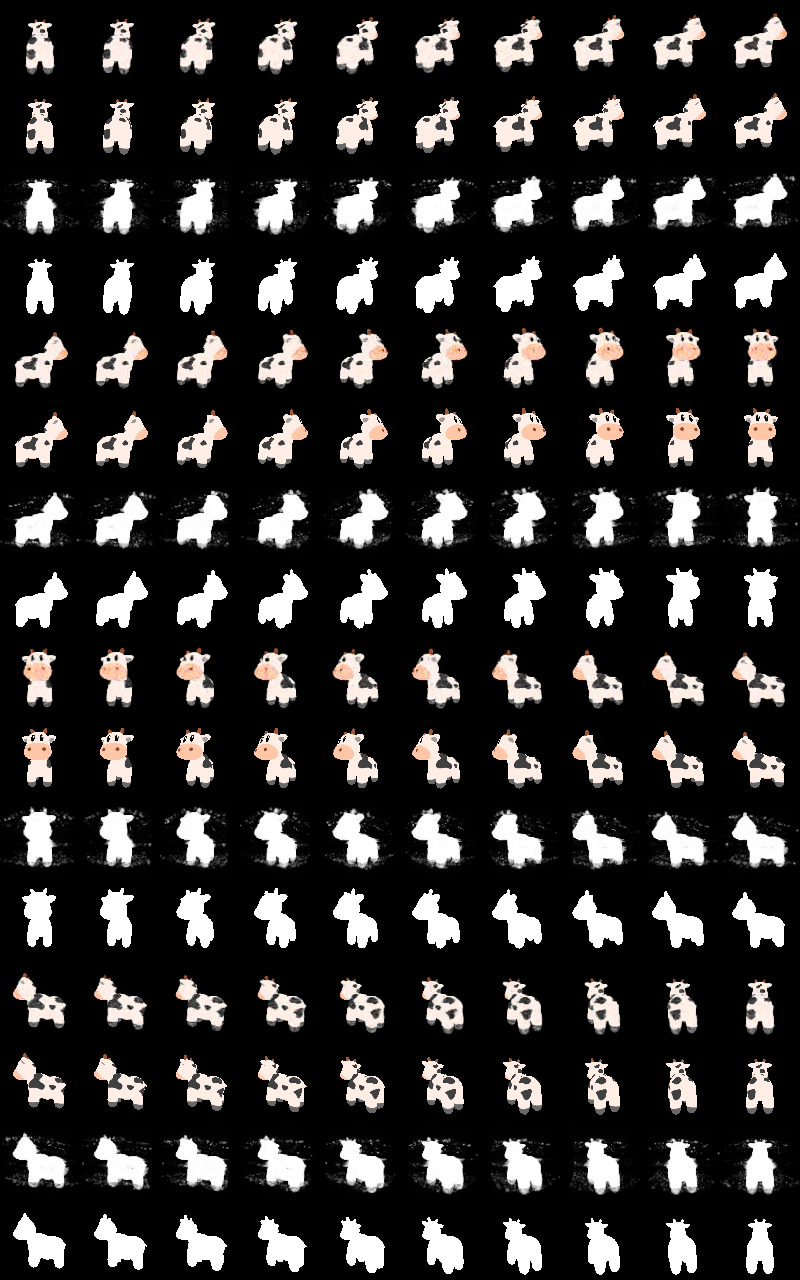

In [18]:
images_to_display = [images.copy(), expected.copy(), masks.copy(), masks_expected.copy()]
n_rows = 4
n_images = len(images)
blank_image = images[0] * 0
n_per_row = 1+(n_images-1)//n_rows
for _ in range(n_per_row*n_rows - n_images):
    for group in images_to_display:
        group.append(blank_image)

images_to_display_listed = [[[i] for i in j] for j in images_to_display]
split = []
for row in range(n_rows):
    for group in images_to_display_listed:
        split.append(group[row*n_per_row:(row+1)*n_per_row])  

Image.fromarray(np.block(split))


In [19]:
# Print the maximum channel intensity in the first image.
print(images[1].max()/255)

0.996078431372549


In [20]:
plt.ioff()
fig, ax = plt.subplots(figsize=(3,3))

ax.grid(None)
ims = [[ax.imshow(im, animated=True)] for im in images]
ani = animation.ArtistAnimation(fig, ims, interval=80, blit=True)
ani_html = ani.to_jshtml()


In [21]:
HTML(ani_html)

In [ ]:
# If you want to see the output of the model with the volume forced to opaque white, run this and re-evaluate
# with torch.no_grad():
#      gm._implicit_functions[0]._fn.density.fill_(9.0)
#      gm._implicit_functions[0]._fn.color.fill_(9.0)
